# Importing Libraries

In [40]:
!pip install imbalanced-learn

In [41]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np
from imblearn.over_sampling import SMOTE



import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Loading and Initizalzation

In [42]:
# Load datasets
ceas08_DF = pd.read_csv('CEAS_08.csv')
spamAssasin_DF = pd.read_csv('SpamAssasin.csv')
nigerian_DF = pd.read_csv('Nigerian_5.csv')

# Combine the DataFrames
df = pd.concat([spamAssasin_DF, ceas08_DF, nigerian_DF], ignore_index=True).copy()

# Optional: Reset the index of the combined DataFrame
df.reset_index(drop=True, inplace=True)

# Convert the 'date' column to datetime format with UTC handling
df['date'] = pd.to_datetime(df['date'], format='%a, %d %b %Y %H:%M:%S %z', errors='coerce', utc=True)

# Remove records with NaT in the 'date' column
df = df.dropna(subset=['date']).copy()

# Extract the year from the 'date' column and create a new 'Year' column
df.loc[:, 'Year'] = df['date'].dt.year

# Drop rows where the year is greater than 2024
df = df[df['Year'] <= 2024].copy()

# Combine subject and body
df['text'] = df['subject'] + " " + df['body']

# Drop the 'sender' and 'receiver' columns
df = df.drop(['sender', 'receiver'], axis=1).copy()

# Handle missing values
df = df.dropna().copy()

# Convert the 'label' and 'urls' columns to integer
df['label'] = df['label'].astype(int)
df['urls'] = df['urls'].astype(int)

df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48846 entries, 0 to 50918
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype              
---  ------   --------------  -----              
 0   date     48846 non-null  datetime64[ns, UTC]
 1   subject  48846 non-null  object             
 2   body     48846 non-null  object             
 3   label    48846 non-null  int64              
 4   urls     48846 non-null  int64              
 5   Year     48846 non-null  int32              
 6   text     48846 non-null  object             
dtypes: datetime64[ns, UTC](1), int32(1), int64(2), object(3)
memory usage: 2.8+ MB


# Preprocessing Data

In [43]:
# Text Preprocessing Function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenization
    words = word_tokenize(text)
    # Remove stopwords and words containing numbers
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and word.isalpha()]
    # Remove words that contain numbers
    words = [word for word in words if not any(char.isdigit() for char in word)]
    #Stemming and Lemmatization
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    words = [ps.stem(lemmatizer.lemmatize(word)) for word in words]
    return ' '.join(words)

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)
df.head()

,date,subject,body,label,urls,Year,text
0,2002-08-22 11:26:25+00:00,Re: New Sequences Window,"Date: Wed, 21 Aug 2002 10:54:46 -0500 ...",0,1,2002,new sequenc window date wed aug chri garrigu m...
1,2002-08-22 11:46:18+00:00,[zzzzteana] RE: Alexander,"Martin A posted:\nTassos Papadopoulos, the Gre...",0,1,2002,zzzzteana alexand martin post tasso papadopoul...
2,2002-08-22 12:52:38+00:00,[zzzzteana] Moscow bomber,Man Threatens Explosion In Moscow \n\nThursday...,0,1,2002,zzzzteana moscow bomber man threaten explos mo...
3,2002-08-22 13:15:25+00:00,[IRR] Klez: The Virus That Won't Die,Klez: The Virus That Won't Die\n \nAlready the...,0,1,2002,irr klez viru wont die klez viru wont die alre...
4,2002-08-22 13:38:22+00:00,Re: [zzzzteana] Nothing like mama used to make,"> in adding cream to spaghetti carbonara, whi...",0,1,2002,zzzzteana noth like mama use make ad cream spa...


Explore the dataset and check how many years of emails are contained within it.

In [44]:
# Check the unique years present in the dataset
unique_years = df['Year'].unique()
sorted_years = sorted(unique_years)

# Display the unique years and the count of emails per year
print(f"Unique years in the dataset: {sorted_years}")



Unique years in the dataset: [1980, 1981, 1986, 1990, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2012, 2015, 2020]


# Time Period Segmentation

The unified dataset contains emails spanning four decades, from 1980 to 2020. The dataset was divided into two distinct time periods to analyze changes over time.

df_earlier contains emails from 1980 to 2007

df_recent contains emails from 2008 to 2020

In [45]:
# Dataset Division (Earlier Emails vs Recent Emails)

df_earlier = df[df['Year'] <= 2007]  # Contains emails from 1980 to 2007
df_recent = df[df['Year'] > 2007]    # Contains emails from 2008 to 2020

# Feature Extraction Using TF-IDF



In [46]:
#Feature Extraction Using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_earlier = tfidf_vectorizer.fit_transform(df_earlier['text'])
y_earlier = df_earlier['label']
X_recent = tfidf_vectorizer.transform(df_recent['text'])
y_recent = df_recent['label']

# Analysis of Dataset

Analysis of Most Common Spam Words before and after 2007

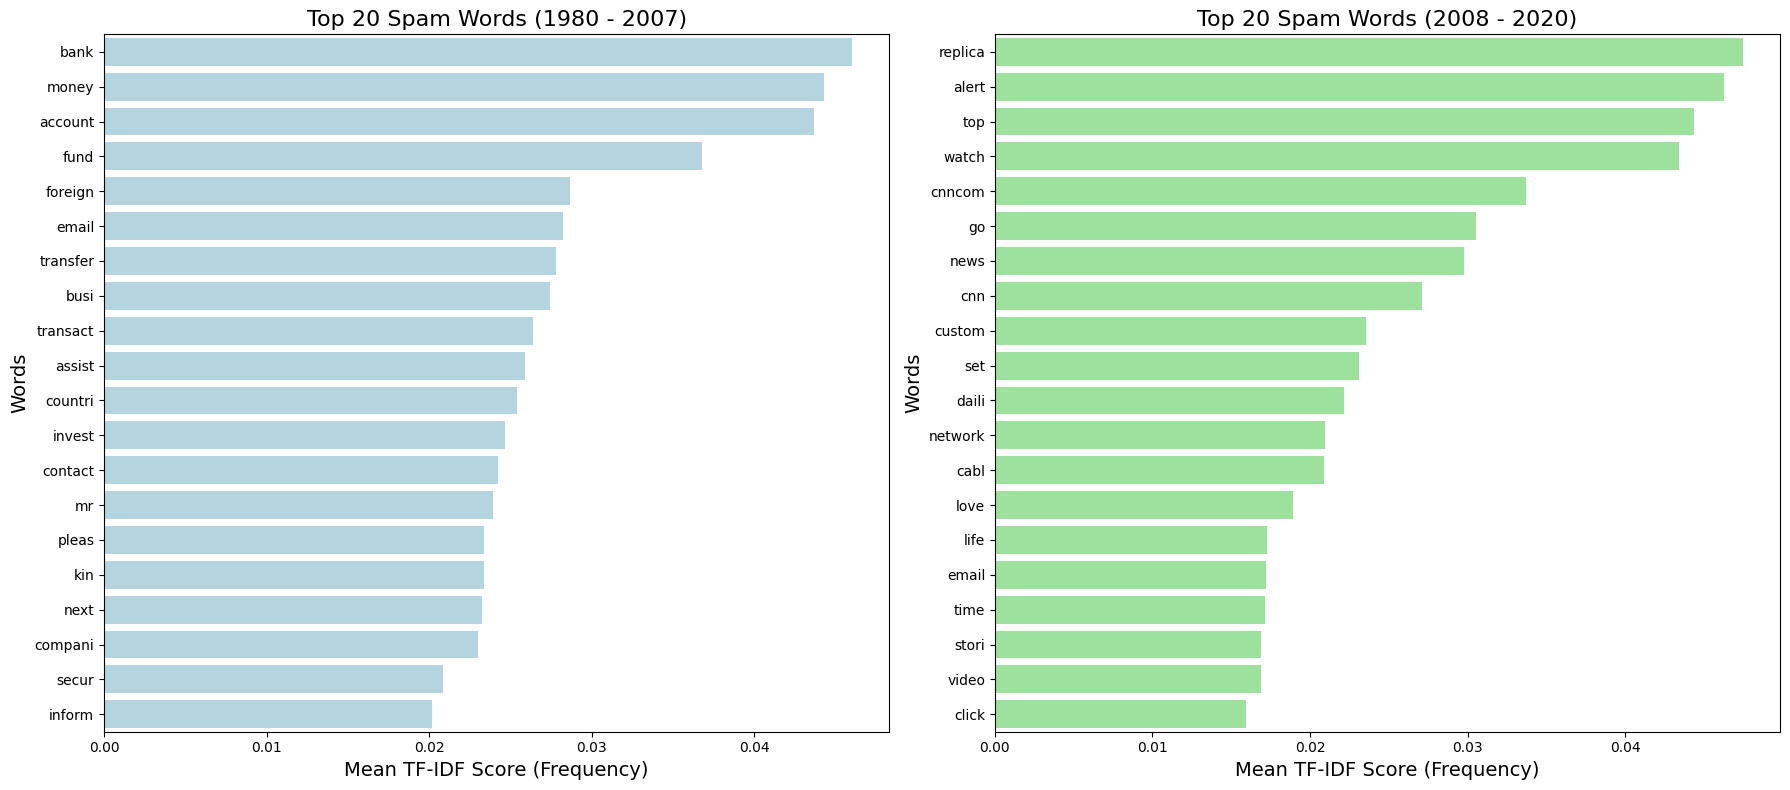

In [47]:
# Earlier spam emails (1980 - 2007)
spam_earlier = df_earlier[df_earlier['label'] == 1]['text']
tfidf_earlier = tfidf_vectorizer.fit_transform(spam_earlier)
earlier_top_words = pd.DataFrame(tfidf_earlier.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).mean().sort_values(ascending=False).head(20)

# Recent spam emails (2008 - 2020)
spam_recent = df_recent[df_recent['label'] == 1]['text']
tfidf_recent = tfidf_vectorizer.fit_transform(spam_recent)
recent_top_words = pd.DataFrame(tfidf_recent.toarray(), columns=tfidf_vectorizer.get_feature_names_out()).mean().sort_values(ascending=False).head(20)

# Plotting the top words with frequency bar graph side by side
def plot_side_by_side_bar_graphs(earlier_top_words, recent_top_words):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

    sns.barplot(x=earlier_top_words.values, y=earlier_top_words.index, ax=axes[0], color='lightblue')
    axes[0].set_title('Top 20 Spam Words (1980 - 2007)', fontsize=16)
    axes[0].set_xlabel('Mean TF-IDF Score (Frequency)', fontsize=14)
    axes[0].set_ylabel('Words', fontsize=14)

    sns.barplot(x=recent_top_words.values, y=recent_top_words.index, ax=axes[1], color='lightgreen')
    axes[1].set_title('Top 20 Spam Words (2008 - 2020)', fontsize=16)
    axes[1].set_xlabel('Mean TF-IDF Score (Frequency)', fontsize=14)
    axes[1].set_ylabel('Words', fontsize=14)

    plt.tight_layout()
    plt.show()

# Visualize side by side
plot_side_by_side_bar_graphs(earlier_top_words, recent_top_words)


# Analysis of Spam Email Content Overtime


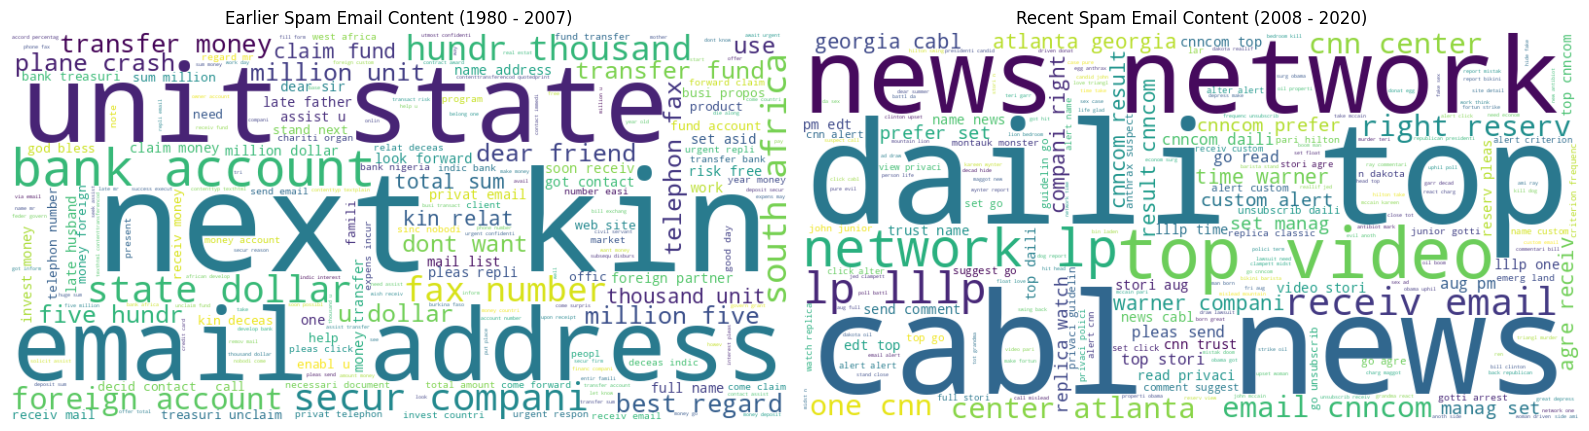

In [48]:
# 2. Word Cloud Analysis of Spam Emails (Content Over Time)
wordcloud_earlier = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_earlier))
wordcloud_recent = WordCloud(width=800, height=400, background_color='white').generate(' '.join(spam_recent))

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(wordcloud_earlier, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('Earlier Spam Email Content (1980 - 2007)')

axes[1].imshow(wordcloud_recent, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Recent Spam Email Content (2008 - 2020)')

plt.tight_layout()
plt.show()


# Format and Topic Change Overtime

In [49]:
# 3. Topic Modeling Analysis
tfidf_all = tfidf_vectorizer.fit_transform(df['text'])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(tfidf_all)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"Topic {topic_idx + 1}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print()

display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 10)

Topic 1:
alert custom email click money bank account receiv cnn fund

Topic 2:
replica watch health top rolex classic love life men gain

Topic 3:
use wrote list mail file messag would like work im

Topic 4:
top passeng cnncom go daili slide video ge evacu gorilla

Topic 5:
top suspect univers cnncom news go paper daili cnn monster



# Analysis of Spam/Ham Distribution (Before and After 2007)

<ipython-input-50-bce636d3318f>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=earlier_dist.index, y=earlier_dist.values, ax=axes[0], palette='Blues_d')
<ipython-input-50-bce636d3318f>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(['Ham', 'Spam'])
<ipython-input-50-bce636d3318f>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=recent_dist.index, y=recent_dist.values, ax=axes[1], palette='Reds_d')
<ipython-input-50-bce636d3318f>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(['Ham', 'Spam'])


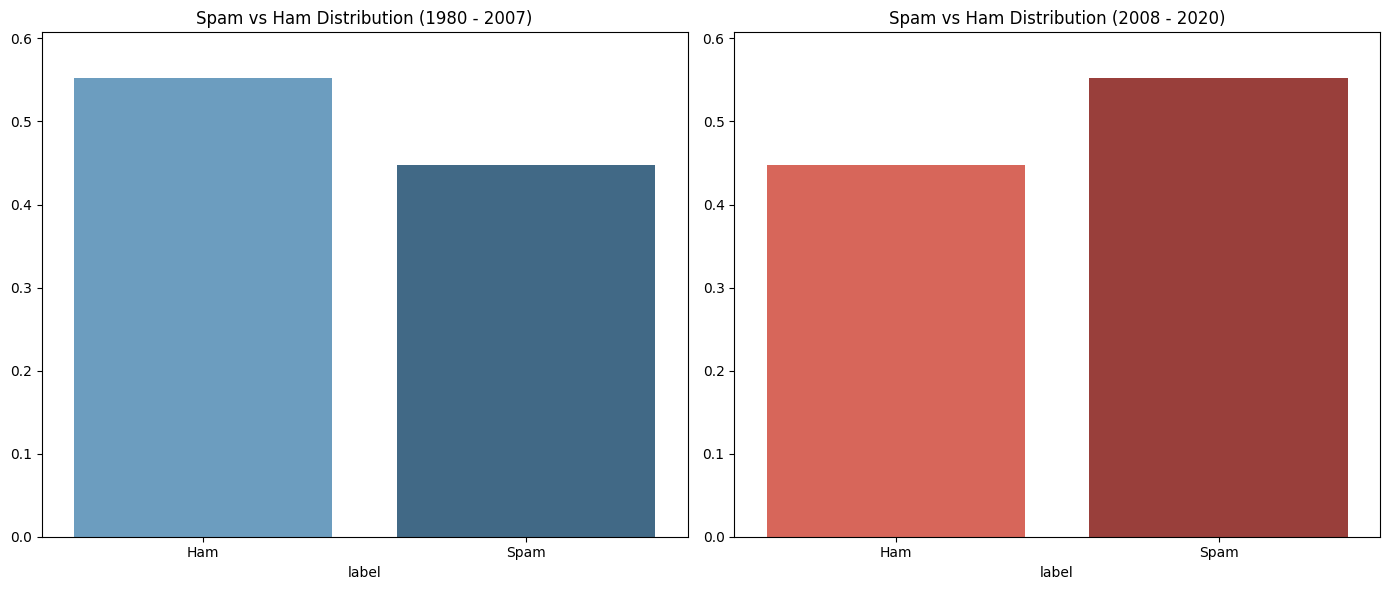

In [50]:
# Calculate the distributions
earlier_dist = df_earlier['label'].value_counts(normalize=True)
recent_dist = df_recent['label'].value_counts(normalize=True)

# Set the y-axis limits to ensure both graphs have the same scale
y_limit = max(earlier_dist.max(), recent_dist.max()) * 1.1  # Slightly larger than the max value

# Create the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for earlier distribution
sns.barplot(x=earlier_dist.index, y=earlier_dist.values, ax=axes[0], palette='Blues_d')
axes[0].set_title('Spam vs Ham Distribution (1980 - 2007)')
axes[0].set_xticklabels(['Ham', 'Spam'])
axes[0].set_ylim(0, y_limit)  # Set the y-axis limits

# Plot for recent distribution
sns.barplot(x=recent_dist.index, y=recent_dist.values, ax=axes[1], palette='Reds_d')
axes[1].set_title('Spam vs Ham Distribution (2008 - 2020)')
axes[1].set_xticklabels(['Ham', 'Spam'])
axes[1].set_ylim(0, y_limit)  # Set the y-axis limits

# Adjust layout and display
plt.tight_layout()
plt.show()


# Train-test Split (Using data from 1980 - 2007)

In [51]:
# Train-test split (Using data from 1980 - 2007)
X_train, X_test, y_train, y_test = train_test_split(X_earlier, y_earlier, test_size=0.2, random_state=42)

In [52]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Precision: {precision:.4f}")
    print(f"{model_name} Recall: {recall:.4f}")
    print(f"{model_name} F1 Score: {f1:.4f}")

    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Cross-validation
def cross_validate_model(model, X, y, model_name):
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


# Logistic Regression Model

1. First, We will build and train LR Model without tuning using earlier emails(1980 - 2007).

Logistic Regression (Without Tuning) Accuracy: 0.9730
Logistic Regression (Without Tuning) Precision: 0.9877
Logistic Regression (Without Tuning) Recall: 0.9504
Logistic Regression (Without Tuning) F1 Score: 0.9687


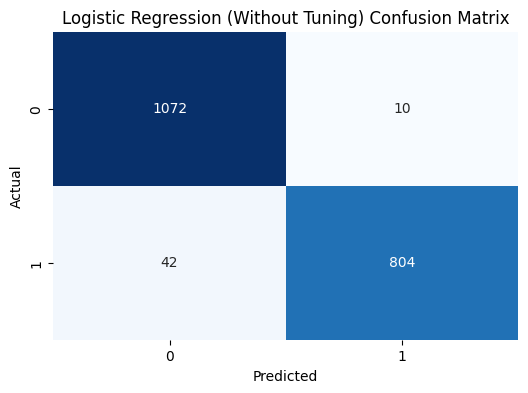

Logistic Regression (Without Tuning) Cross-Validation Accuracy: 0.9739 ± 0.0035


In [53]:
# Logistic Regression Model (Without Tuning)
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

# Evaluate Logistic Regression (Without Tuning)
evaluate_model(y_test, lr_pred, "Logistic Regression (Without Tuning)")
cross_validate_model(lr, X_train, y_train, "Logistic Regression (Without Tuning)")

2. Then, we will tune the LR Model and evaluate the tuned LR performance.

Logistic Regression (After Tuning) Accuracy: 0.9850
Logistic Regression (After Tuning) Precision: 0.9928
Logistic Regression (After Tuning) Recall: 0.9728
Logistic Regression (After Tuning) F1 Score: 0.9827


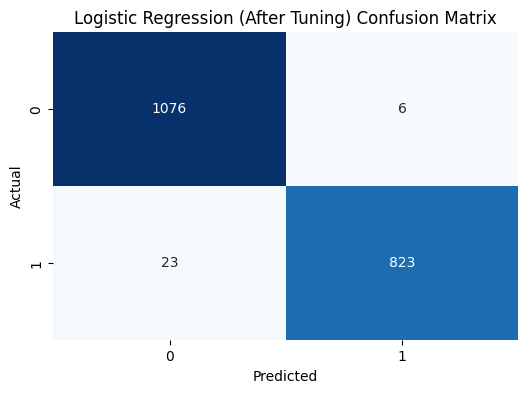

Logistic Regression (After Tuning) Cross-Validation Accuracy: 0.9855 ± 0.0026


In [54]:
# Hyperparameter Tuning for Logistic Regression
lr_params = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
lr_grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=5, scoring='accuracy')
lr_grid.fit(X_train, y_train)
lr_tuned_pred = lr_grid.predict(X_test)

# Evaluate Logistic Regression (After Tuning)
evaluate_model(y_test, lr_tuned_pred, "Logistic Regression (After Tuning)")
cross_validate_model(lr_grid.best_estimator_, X_train, y_train, "Logistic Regression (After Tuning)")


Visualize and compare the performance of LR Model before and after tuning

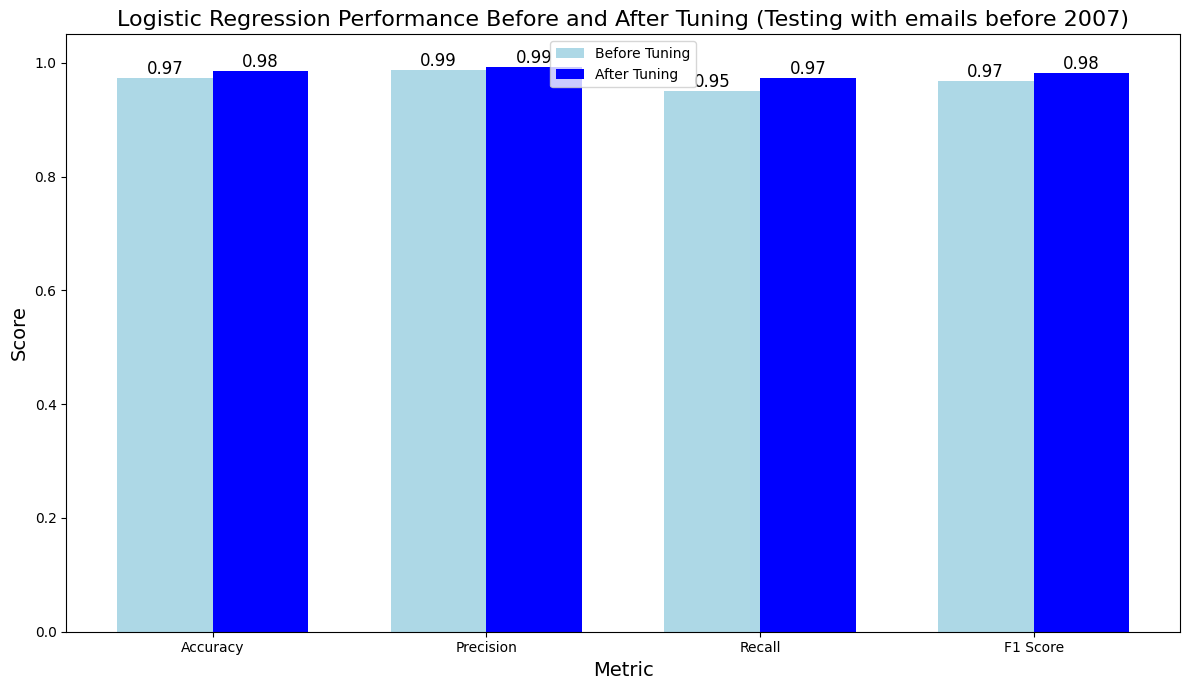

In [55]:
# Function to add bar labels
def add_bar_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=12)


# Visualization of LR Model Performance Before and After Tuning
lr_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Before Tuning': [
        accuracy_score(y_test, lr_pred),
        precision_score(y_test, lr_pred),
        recall_score(y_test, lr_pred),
        f1_score(y_test, lr_pred)
    ],
    'After Tuning': [
        accuracy_score(y_test, lr_tuned_pred),
        precision_score(y_test, lr_tuned_pred),
        recall_score(y_test, lr_tuned_pred),
        f1_score(y_test, lr_tuned_pred)
    ]
})

# Plotting Logistic Regression Metrics
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(lr_metrics['Metric']))

bars_before_tuning = ax.bar(index - bar_width/2, lr_metrics['Before Tuning'], bar_width, label='Before Tuning', color='lightblue')
bars_after_tuning = ax.bar(index + bar_width/2, lr_metrics['After Tuning'], bar_width, label='After Tuning', color='blue')

ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Logistic Regression Performance Before and After Tuning (Testing with emails before 2007)', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(lr_metrics['Metric'])
ax.set_ylim([0, 1.05])  # Slightly increase the upper limit of y-axis to create space above bars

ax.legend()
add_bar_labels(bars_before_tuning)
add_bar_labels(bars_after_tuning)
plt.tight_layout()
plt.show()


# Ensemble Model

1. First we will build the ensemble model without tuning and train and test the model using earlier emails (1980 - 2007).

Ensemble Model (Without Tuning) Accuracy: 0.9844
Ensemble Model (Without Tuning) Precision: 0.9904
Ensemble Model (Without Tuning) Recall: 0.9740
Ensemble Model (Without Tuning) F1 Score: 0.9821


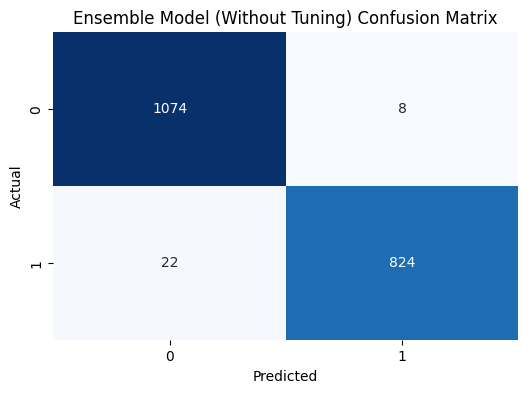

In [56]:
# Oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Ensemble Model (Without Tuning)
nb = MultinomialNB()
svm = SVC(probability=True, random_state=42)
ensemble = VotingClassifier(estimators=[('lr', lr), ('nb', nb), ('svm', svm)], voting='soft')
ensemble.fit(X_train_res, y_train_res)
ensemble_pred = ensemble.predict(X_test)

# Evaluate Ensemble Model (Without Tuning)
evaluate_model(y_test, ensemble_pred, "Ensemble Model (Without Tuning)")
#cross_validate_model(ensemble, X_train, y_train, "Ensemble Model (Without Tuning)")

2. Then, we will tune the ensemble model and evaluate the performance.

Ensemble Model (After Tuning) Accuracy: 0.9912
Ensemble Model (After Tuning) Precision: 0.9940
Ensemble Model (After Tuning) Recall: 0.9858
Ensemble Model (After Tuning) F1 Score: 0.9899


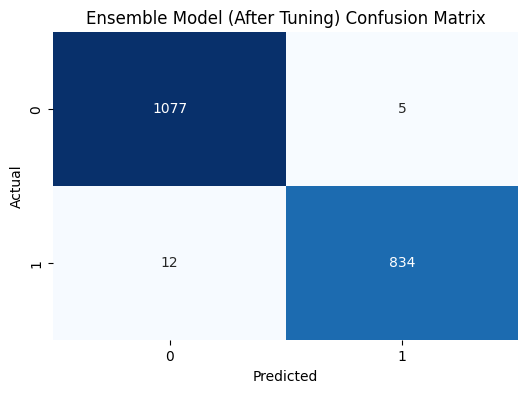

In [57]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from scipy.stats import uniform

#LR Tuning
lr_grid2 = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), lr_params, cv=5, scoring='accuracy')
lr_grid2.fit(X_train_res, y_train_res)

# SVM Tuning with RandomizedSearchCV
svm_params = {
    'C': uniform(loc=0.1, scale=4.9),  # Fine-tuned range for C
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']  # Simplified gamma options
}

# RandomizedSearchCV setup
svm_random_search = RandomizedSearchCV(
    SVC(probability=True, random_state=42),
    svm_params,
    n_iter=5,  #number of random combinations
    cv=3,  # cross-validation folds
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Fit the model
svm_random_search.fit(X_train_res, y_train_res)

# Use the best estimator found
best_svm_model = svm_random_search.best_estimator_

# Naive Bayes Tuning
nb_tuned = MultinomialNB(alpha=0.5)  # Slight smoothing applied to Naive Bayes

# Continue with ensemble model evaluation
ensemble_tuned = VotingClassifier(estimators=[
    ('lr', lr_grid2.best_estimator_),
    ('nb', nb_tuned),
    ('svm', best_svm_model)
], voting='soft', weights=[1, 1, 2], n_jobs=-1)
ensemble_tuned.fit(X_train_res, y_train_res)
ensemble_tuned_pred = ensemble_tuned.predict(X_test)

# Evaluate Ensemble Model (After Tuning)
evaluate_model(y_test, ensemble_tuned_pred, "Ensemble Model (After Tuning)")
#cross_validate_model(ensemble_tuned, X_train, y_train, "Ensemble Model (After Tuning)")

Visualize and Compare the Ensemble Model Performance Before and After Tuning

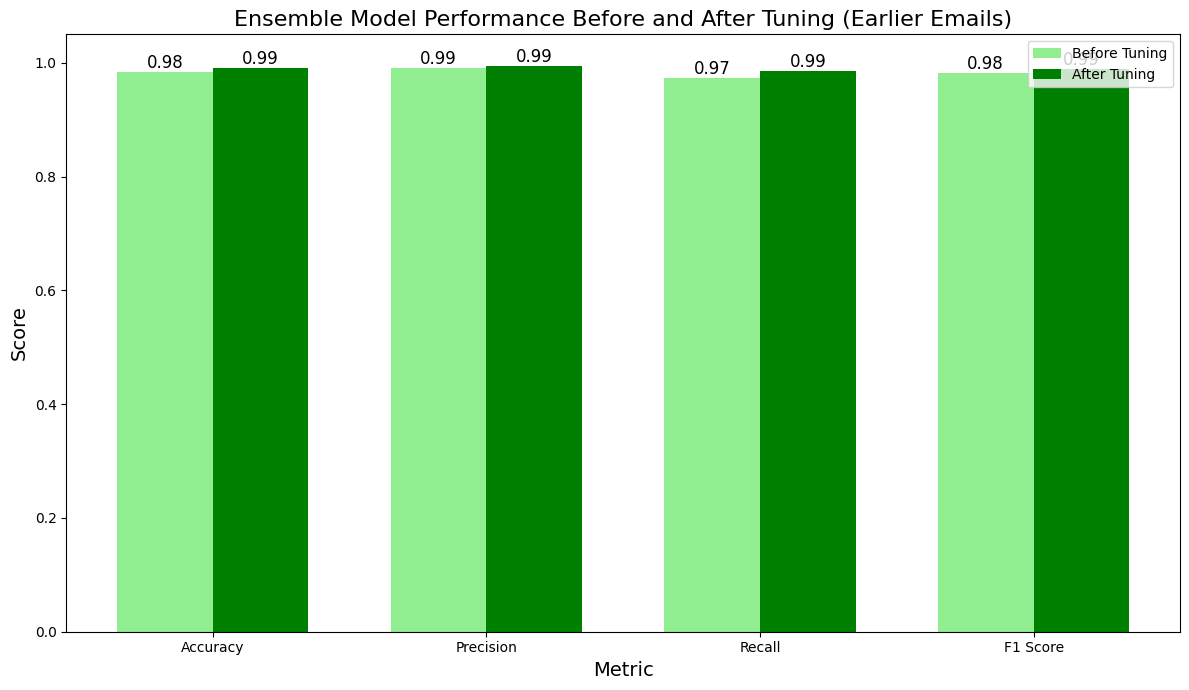

In [58]:
# Visualization of Ensemble Model Performance Before and After Tuning (Using Emails Before 2007)
ensemble_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Before Tuning': [
        accuracy_score(y_test, ensemble_pred),
        precision_score(y_test, ensemble_pred),
        recall_score(y_test, ensemble_pred),
        f1_score(y_test, ensemble_pred)
    ],
    'After Tuning': [
        accuracy_score(y_test, ensemble_tuned_pred),
        precision_score(y_test, ensemble_tuned_pred),
        recall_score(y_test, ensemble_tuned_pred),
        f1_score(y_test, ensemble_tuned_pred)
    ]
})

# Plotting Ensemble Model Metrics Before and After Tuning
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(ensemble_metrics['Metric']))

bars_before_tuning = ax.bar(index - bar_width/2, ensemble_metrics['Before Tuning'], bar_width, label='Before Tuning', color='lightgreen')
bars_after_tuning = ax.bar(index + bar_width/2, ensemble_metrics['After Tuning'], bar_width, label='After Tuning', color='green')

ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Ensemble Model Performance Before and After Tuning (Earlier Emails)', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(ensemble_metrics['Metric'])
ax.set_ylim([0, 1.05])

ax.legend()
add_bar_labels(bars_before_tuning)
add_bar_labels(bars_after_tuning)
plt.tight_layout()
plt.show()


# Comparison of the two model performance after tuning

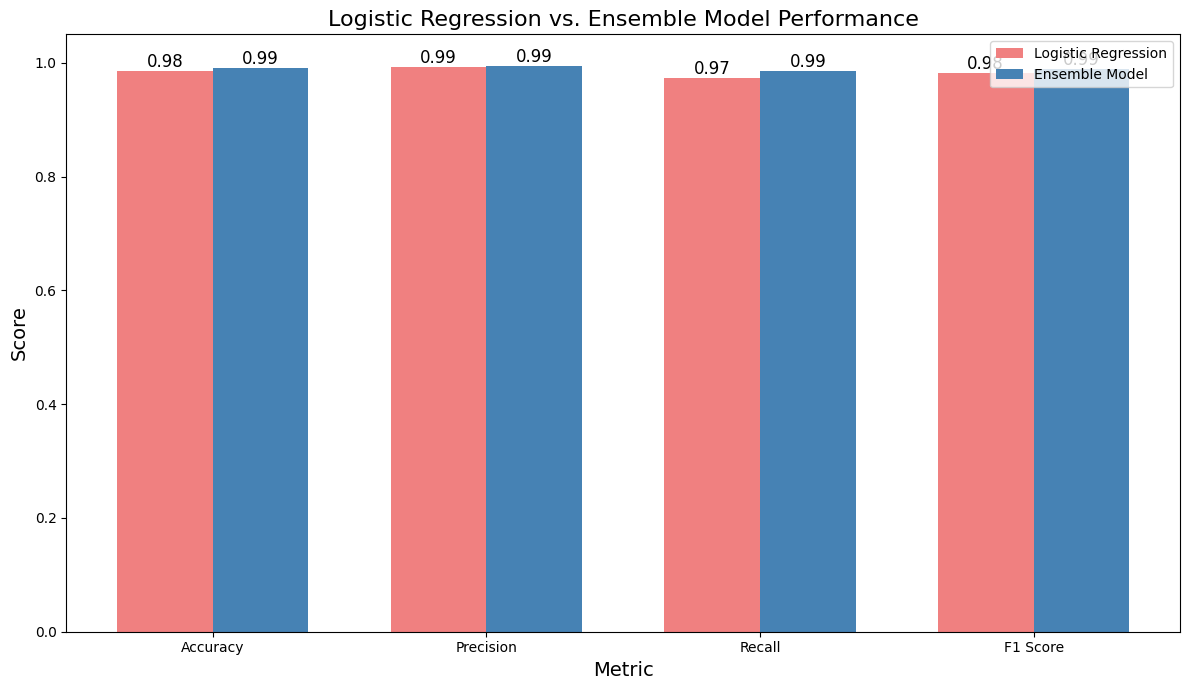

In [59]:
# Logistic Regression vs Ensemble Model Comparison After Tuning
model_comparison_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Logistic Regression': [
        accuracy_score(y_test, lr_tuned_pred),
        precision_score(y_test, lr_tuned_pred),
        recall_score(y_test, lr_tuned_pred),
        f1_score(y_test, lr_tuned_pred)
    ],
    'Ensemble Model': [
        accuracy_score(y_test, ensemble_tuned_pred),
        precision_score(y_test, ensemble_tuned_pred),
        recall_score(y_test, ensemble_tuned_pred),
        f1_score(y_test, ensemble_tuned_pred)
    ]
})

# Plotting Logistic Regression vs Ensemble Model
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(model_comparison_metrics['Metric']))

bars_lr = ax.bar(index - bar_width/2, model_comparison_metrics['Logistic Regression'], bar_width, label='Logistic Regression', color='lightcoral')
bars_ensemble = ax.bar(index + bar_width/2, model_comparison_metrics['Ensemble Model'], bar_width, label='Ensemble Model', color='steelblue')

ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Logistic Regression vs. Ensemble Model Performance', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(model_comparison_metrics['Metric'])
ax.set_ylim([0, 1.05])

ax.legend()
add_bar_labels(bars_lr)
add_bar_labels(bars_ensemble)
plt.tight_layout()
plt.show()


# Testing Both Models With Recent Unseen Emails (2008 - 2020)

We will test out both models with recent email data (2008 - 2020). These emails are different from the training data.

Logistic Regression (After 2007) Accuracy: 0.8156
Logistic Regression (After 2007) Precision: 0.9640
Logistic Regression (After 2007) Recall: 0.6919
Logistic Regression (After 2007) F1 Score: 0.8056


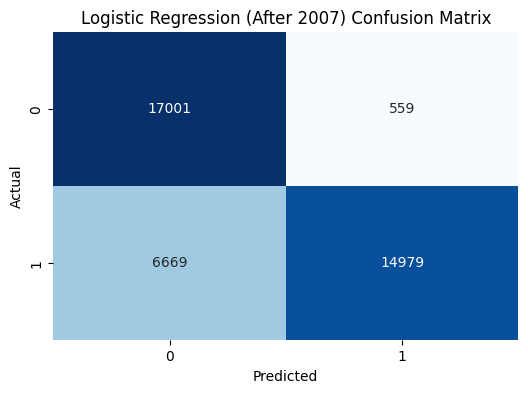

Ensemble Model (After 2007) Accuracy: 0.9018
Ensemble Model (After 2007) Precision: 0.9684
Ensemble Model (After 2007) Recall: 0.8500
Ensemble Model (After 2007) F1 Score: 0.9053


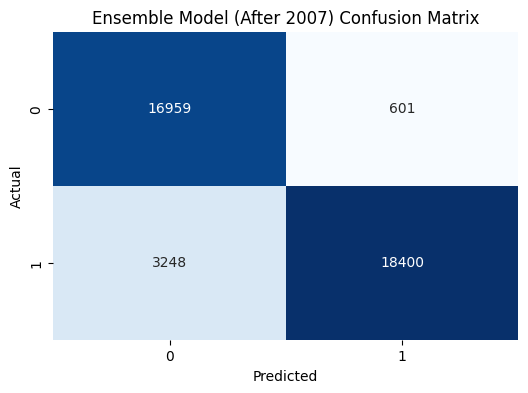

In [60]:
# Test Models with recent unseen data (Dataset Shift)
lr_recent_pred = lr_grid.predict(X_recent)
ensemble_recent_pred = ensemble_tuned.predict(X_recent)

# Evaluate on Recent Data
evaluate_model(y_recent, lr_recent_pred, "Logistic Regression (After 2007)")
evaluate_model(y_recent, ensemble_recent_pred, "Ensemble Model (After 2007)")


# Evaluation of Performance Degradration Due to Dataset Shift

1. Evaluation of LR Model Before and After Dataset Shift (When test the model with recent emails)

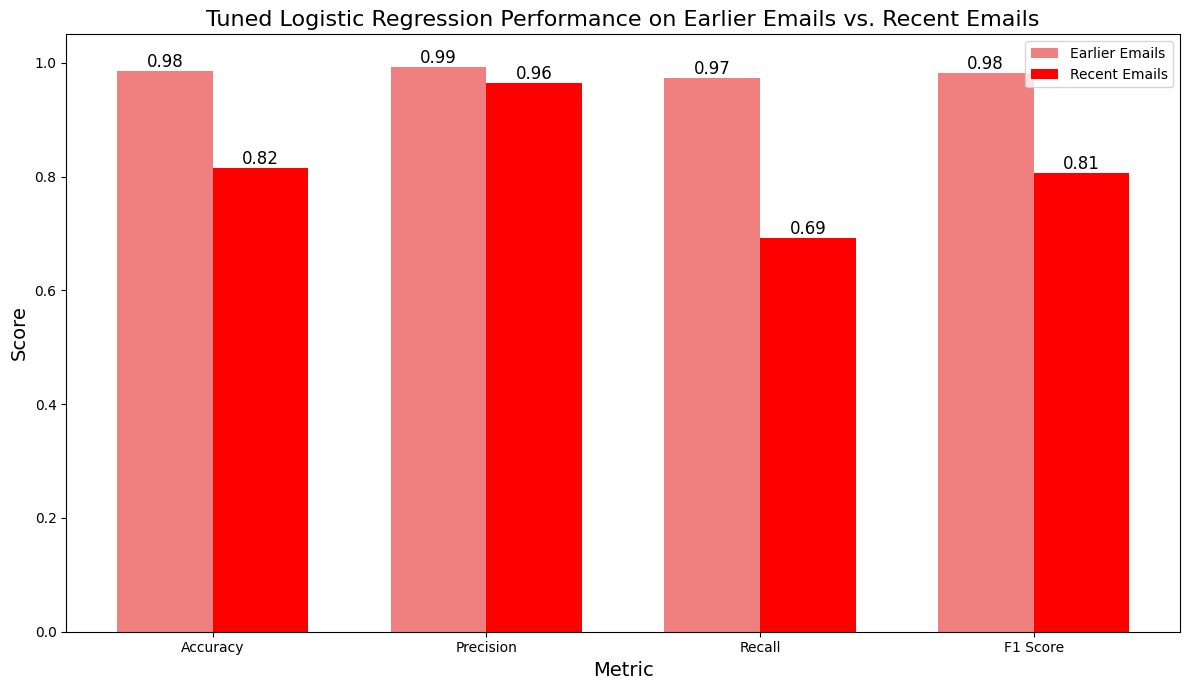

In [61]:
# Comparison of LR Model Performance on Earlier vs Recent Emails
lr_time_comparison_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Earlier Emails': [
        accuracy_score(y_test, lr_tuned_pred),
        precision_score(y_test, lr_tuned_pred),
        recall_score(y_test, lr_tuned_pred),
        f1_score(y_test, lr_tuned_pred)
    ],
    'Recent Emails': [
        accuracy_score(y_recent, lr_recent_pred),
        precision_score(y_recent, lr_recent_pred),
        recall_score(y_recent, lr_recent_pred),
        f1_score(y_recent, lr_recent_pred)
    ]
})

# Plotting Tuned Logistic Regression on Earlier vs. Recent Emails
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(lr_time_comparison_metrics['Metric']))

bars_earlier = ax.bar(index - bar_width/2, lr_time_comparison_metrics['Earlier Emails'], bar_width, label='Earlier Emails', color='lightcoral')
bars_recent = ax.bar(index + bar_width/2, lr_time_comparison_metrics['Recent Emails'], bar_width, label='Recent Emails', color='red')

ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Tuned Logistic Regression Performance on Earlier Emails vs. Recent Emails', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(lr_time_comparison_metrics['Metric'])
ax.set_ylim([0, 1.05])

ax.legend()
add_bar_labels(bars_earlier)
add_bar_labels(bars_recent)
plt.tight_layout()
plt.show()


2. Evaluation of Ensemble Model Before and After Dataset Shift

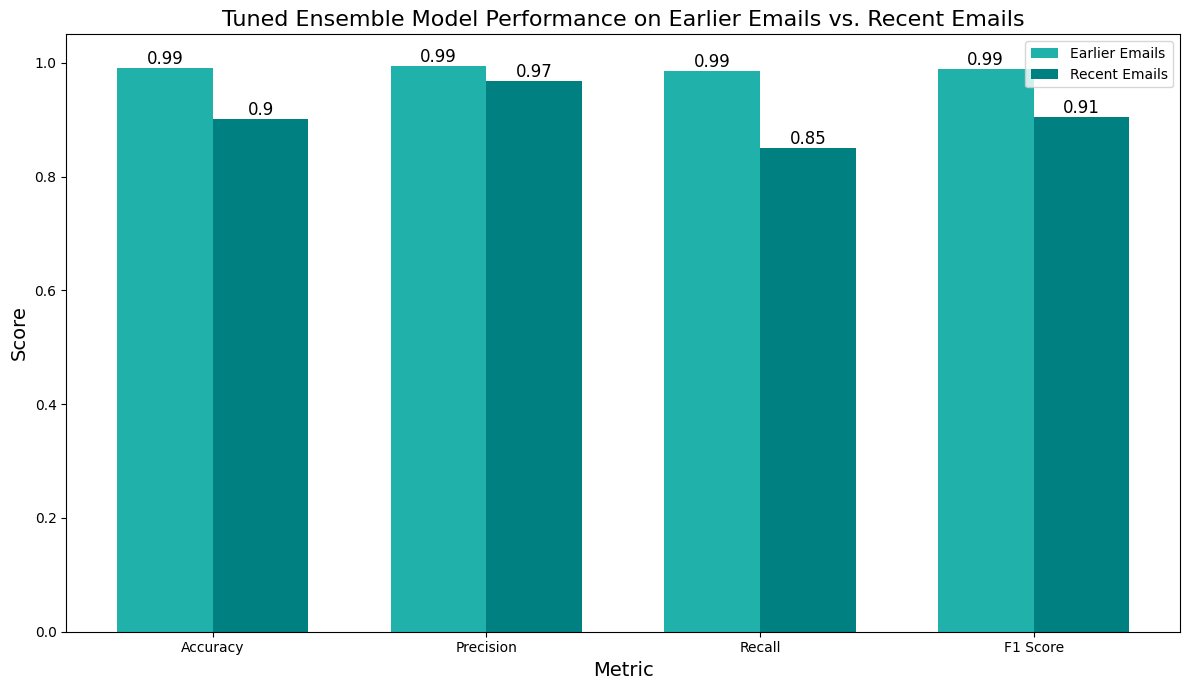

In [62]:
# Prepare Data for Tuned Ensemble Metrics on Earlier vs. Recent Emails
ensemble_time_comparison_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Earlier Emails': [
        accuracy_score(y_test, ensemble_tuned_pred),
        precision_score(y_test, ensemble_tuned_pred),
        recall_score(y_test, ensemble_tuned_pred),
        f1_score(y_test, ensemble_tuned_pred)
    ],
    'Recent Emails': [
        accuracy_score(y_recent, ensemble_recent_pred),
        precision_score(y_recent, ensemble_recent_pred),
        recall_score(y_recent, ensemble_recent_pred),
        f1_score(y_recent, ensemble_recent_pred)
    ]
})

# Plotting Tuned Ensemble on Earlier vs. Recent Emails
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(ensemble_time_comparison_metrics['Metric']))

bars_earlier = ax.bar(index - bar_width/2, ensemble_time_comparison_metrics['Earlier Emails'], bar_width, label='Earlier Emails', color='lightseagreen')
bars_recent = ax.bar(index + bar_width/2, ensemble_time_comparison_metrics['Recent Emails'], bar_width, label='Recent Emails', color='teal')

ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Tuned Ensemble Model Performance on Earlier Emails vs. Recent Emails', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(ensemble_time_comparison_metrics['Metric'])
ax.set_ylim([0, 1.05])

ax.legend()
add_bar_labels(bars_earlier)
add_bar_labels(bars_recent)
plt.tight_layout()
plt.show()


# Comparison of model performance between LR model and Ensemble Model under dataset shift

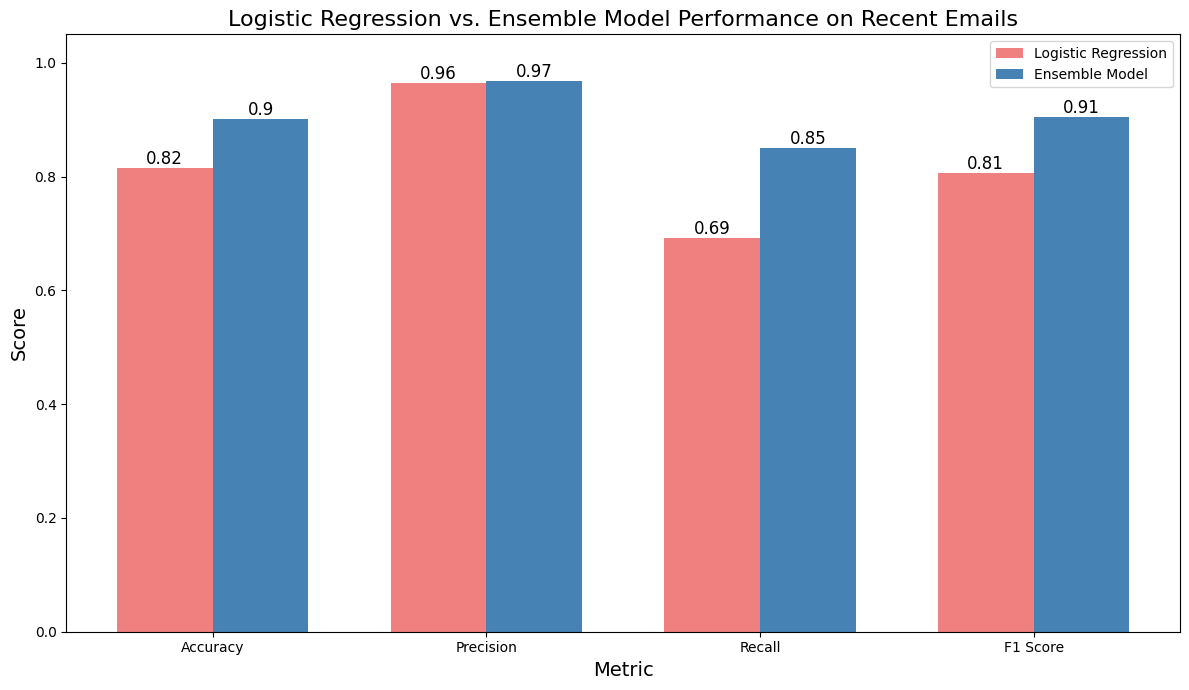

In [63]:
# Prepare Data for Logistic Regression vs Ensemble Model Comparison on Recent Emails
recent_model_comparison_metrics = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Logistic Regression': [
        accuracy_score(y_recent, lr_recent_pred),
        precision_score(y_recent, lr_recent_pred),
        recall_score(y_recent, lr_recent_pred),
        f1_score(y_recent, lr_recent_pred)
    ],
    'Ensemble Model': [
        accuracy_score(y_recent, ensemble_recent_pred),
        precision_score(y_recent, ensemble_recent_pred),
        recall_score(y_recent, ensemble_recent_pred),
        f1_score(y_recent, ensemble_recent_pred)
    ]
})

# Plotting Logistic Regression vs Ensemble Model for Recent Emails
fig, ax = plt.subplots(figsize=(12, 7))
bar_width = 0.35
index = np.arange(len(recent_model_comparison_metrics['Metric']))

bars_lr = ax.bar(index - bar_width/2, recent_model_comparison_metrics['Logistic Regression'], bar_width, label='Logistic Regression', color='lightcoral')
bars_ensemble = ax.bar(index + bar_width/2, recent_model_comparison_metrics['Ensemble Model'], bar_width, label='Ensemble Model', color='steelblue')

ax.set_xlabel('Metric', fontsize=14)
ax.set_ylabel('Score', fontsize=14)
ax.set_title('Logistic Regression vs. Ensemble Model Performance on Recent Emails', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(recent_model_comparison_metrics['Metric'])
ax.set_ylim([0, 1.05])

ax.legend()
add_bar_labels(bars_lr)
add_bar_labels(bars_ensemble)
plt.tight_layout()
plt.show()


# Testing Spam Filter in Real-Time

In [65]:
def predict_spam(email_text):
    # Preprocess the email
    preprocessed_email = preprocess_text(email_text)

    # Convert the preprocessed email to TF-IDF features
    email_features = tfidf_vectorizer.transform([preprocessed_email])

    # Use the ensemble model to predict
    prediction = ensemble_tuned.predict(email_features)

    # Convert the prediction to a label
    label = 'Spam' if prediction[0] == 1 else 'Ham'

    return label

# Example usage:
email_input = input("Enter the email text: ")
result = predict_spam(email_input)
print(f"The email is classified as: {result}")


Enter the email text: You’ve Won a Free Vacation! 🌴 Claim Your Prize Now!  Body: Congratulations! You’ve been selected to win an all-expenses-paid vacation to a tropical paradise. Imagine relaxing on white sandy beaches with crystal-clear waters. It’s all possible with our exclusive offer!  🏖️ 7 nights in a luxury resort ✈️ Round-trip airfare included 🍹 All-inclusive meals and drinks  Don’t wait! Claim your prize now by clicking the link below:  👉 Claim Your Free Vacation  Hurry, this offer is limited to the first 50 respondents!
The email is classified as: Spam
